### Algorithm: CNN-LSTM including normalization
### Created: November 30, 2023, Abril 13,2024
### Dataset : DuckDuckGeese
### Authors: Edgar Acuna and Roxana Aparicio


In [181]:
# cnn lstm model
from numpy import mean
from numpy import std, unique
from numpy import dstack
from pandas import read_csv
#from keras.models import Sequential
##from keras.layers import Dense
#from keras.layers import Flatten
#from keras.layers import Dropout
#from keras.layers import LSTM
#from keras.layers import TimeDistributed
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
#from keras.utils import to_categorical
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, roc_auc_score, ConfusionMatrixDisplay
import tensorflow.keras.layers as layers
import keras
from numpy import mean
from numpy import std, unique
from numpy import dstack
from pandas import read_csv
#from keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical

# load a single file as a numpy array
#def load_file(filepath):
#    dataframe = read_csv(filepath, header=None)
#    return dataframe.values

In [182]:
import pandas as pd
from aeon.datasets import load_classification
from sklearn import preprocessing

import pandas as pd
from aeon.datasets import load_classification
from sklearn import preprocessing

def load_data(dataset, split="Train"):
    if split=="Train":
        X, y, meta_data = load_classification(dataset, split="Train")
    else:
        X, y, meta_data = load_classification(dataset, split="Test")
    print(" Shape of X = ", X.shape)
    print(" Shape of y = ", y.shape)
    #Swap dimensions so features are the third dimension
    X = X.swapaxes(1, 2)
    print(" New shape of X = ", X.shape)
    #prepare y
    y = pd.DataFrame(y)
    enc = preprocessing.OneHotEncoder(dtype=int)
    enc.fit(y)
    y = enc.transform(y).toarray()
    print(" New shape of y = ", y.shape)
    return X, y


In [183]:
# loading Training data
X, y = load_data("DuckDuckGeese",split="Train")
print(y.shape)

 Shape of X =  (50, 1345, 270)
 Shape of y =  (50,)
 New shape of X =  (50, 270, 1345)
 New shape of y =  (50, 5)
(50, 5)


In [184]:
# loading Testing data
Xt, yt = load_data("DuckDuckGeese",split="Test")

 Shape of X =  (50, 1345, 270)
 Shape of y =  (50,)
 New shape of X =  (50, 270, 1345)
 New shape of y =  (50, 5)


In [185]:
import numpy as np
Xb= np.concatenate((X, Xt),axis=0)
print(Xb.shape)

(100, 270, 1345)


(13500, 1345)


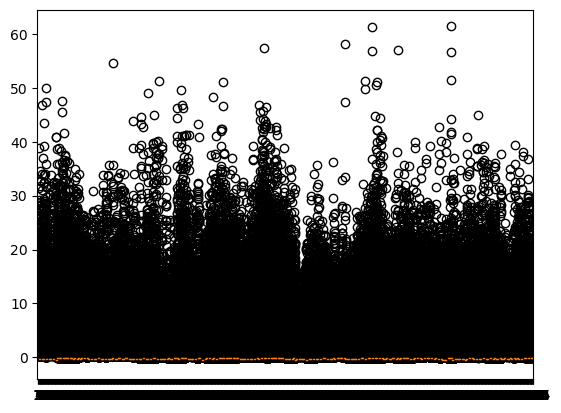

In [186]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tempo=X.reshape(X.shape[2],-1).T
#print(tempo.shape)
X = scaler.fit_transform(X.reshape(X.shape[2], -1)).reshape(X.shape)
Xb = scaler.fit_transform(Xb.reshape(Xb.shape[2], -1)).reshape(Xb.shape)
Xt = scaler.fit_transform(Xt.reshape(Xt.shape[2], -1)).reshape(Xt.shape)
X1 = scaler.fit_transform(tempo)
#print(X)
tempodf=pd.DataFrame(X1)
print(tempodf.shape)
pyplot.boxplot(tempodf)
pyplot.show()

In [187]:
Xn1=Xb[0:50]
print(Xn1.shape)
Xn2=Xb[50:100]
print(Xn2.shape)

(50, 270, 1345)
(50, 270, 1345)


In [188]:
# define model
import time
verbose, epochs, batch_size = 1, 300, 4
#trainX, trainy, testX, testy = trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)
trainX=Xn1
trainy=y
testX=Xn2
testy=yt
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print(n_features)
# reshape data into time steps of sub-sequences
n_steps, n_length =3,90
#For P#n_steps, n_length = 5, 20
print(trainX.shape)
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
print(trainX.shape)
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
#print("number of features",n_features)
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
#model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
#model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv1D(filters=512, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
model.add(TimeDistributed(Flatten()))
#model.add(Dropout(0.5))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
start_time=time.time()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
test_results= model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
#print(test_results)

1345
(50, 270, 1345)
(50, 3, 90, 1345)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_135 (TimeD  (None, None, 89, 32)     86112     
 istributed)                                                     
                                                                 
 time_distributed_136 (TimeD  (None, None, 44, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_137 (TimeD  (None, None, 43, 64)     4160      
 istributed)                                                     
                                                                 
 time_distributed_138 (TimeD  (None, None, 14, 64)     0         
 istributed)                                                     
                                                                 
 time_distribu

13/13 [==============================] - 0s 16ms/step - loss: 0.3046 - accuracy: 0.8000
Epoch 53/300
13/13 [==============================] - 0s 15ms/step - loss: 0.3000 - accuracy: 0.7800
Epoch 54/300
13/13 [==============================] - 0s 17ms/step - loss: 0.2963 - accuracy: 0.8000
Epoch 55/300
13/13 [==============================] - 0s 16ms/step - loss: 0.3038 - accuracy: 0.7600
Epoch 56/300
13/13 [==============================] - 0s 16ms/step - loss: 0.2862 - accuracy: 0.8200
Epoch 57/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2921 - accuracy: 0.8000
Epoch 58/300
13/13 [==============================] - 0s 19ms/step - loss: 0.2823 - accuracy: 0.7800
Epoch 59/300
13/13 [==============================] - 0s 19ms/step - loss: 0.2799 - accuracy: 0.8200
Epoch 60/300
13/13 [==============================] - 0s 19ms/step - loss: 0.2815 - accuracy: 0.7800
Epoch 61/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2862 - accuracy: 0.8200
Epo

13/13 [==============================] - 0s 18ms/step - loss: 0.2888 - accuracy: 0.7800
Epoch 133/300
13/13 [==============================] - 0s 17ms/step - loss: 0.2763 - accuracy: 0.8200
Epoch 134/300
13/13 [==============================] - 0s 19ms/step - loss: 0.2755 - accuracy: 0.8200
Epoch 135/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2761 - accuracy: 0.8000
Epoch 136/300
13/13 [==============================] - 0s 17ms/step - loss: 0.2963 - accuracy: 0.7600
Epoch 137/300
13/13 [==============================] - 0s 17ms/step - loss: 0.2805 - accuracy: 0.7800
Epoch 138/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2797 - accuracy: 0.7600
Epoch 139/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2578 - accuracy: 0.8200
Epoch 140/300
13/13 [==============================] - 0s 18ms/step - loss: 0.4045 - accuracy: 0.8200
Epoch 141/300
13/13 [==============================] - 0s 17ms/step - loss: 0.2968 - accuracy: 0

13/13 [==============================] - 0s 18ms/step - loss: 0.2661 - accuracy: 0.7800
Epoch 213/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2729 - accuracy: 0.7600
Epoch 214/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2635 - accuracy: 0.8200
Epoch 215/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2654 - accuracy: 0.8000
Epoch 216/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2665 - accuracy: 0.8200
Epoch 217/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2657 - accuracy: 0.8200
Epoch 218/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2651 - accuracy: 0.8200
Epoch 219/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2721 - accuracy: 0.7800
Epoch 220/300
13/13 [==============================] - 0s 17ms/step - loss: 0.2671 - accuracy: 0.8000
Epoch 221/300
13/13 [==============================] - 0s 18ms/step - loss: 0.2653 - accuracy: 0

13/13 [==============================] - 0s 20ms/step - loss: 1.0428 - accuracy: 0.4400
Epoch 293/300
13/13 [==============================] - 0s 18ms/step - loss: 1.0309 - accuracy: 0.4600
Epoch 294/300
13/13 [==============================] - 0s 19ms/step - loss: 1.0206 - accuracy: 0.4000
Epoch 295/300
13/13 [==============================] - 0s 18ms/step - loss: 1.0663 - accuracy: 0.3400
Epoch 296/300
13/13 [==============================] - 0s 17ms/step - loss: 1.0299 - accuracy: 0.4000
Epoch 297/300
13/13 [==============================] - 0s 17ms/step - loss: 1.0625 - accuracy: 0.3000
Epoch 298/300
13/13 [==============================] - 0s 16ms/step - loss: 1.0305 - accuracy: 0.3400
Epoch 299/300
13/13 [==============================] - 0s 17ms/step - loss: 1.0233 - accuracy: 0.4400
Epoch 300/300
13/13 [==============================] - 0s 17ms/step - loss: 1.0178 - accuracy: 0.4600


In [189]:
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
print("Training time:---  %s seconds ---" % (time.time() - start_time))

Test results - Loss: 2.016648769378662 - Accuracy: 0.36000001430511475%
Training time:---  70.8709659576416 seconds ---


In [190]:
#Computing F1-score
import numpy as np
import sklearn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, roc_auc_score
train_features = np.array(trainX)
test_features = np.array(testX)
train_labels=np.array(trainy)
#train_labels=pd.DataFrame(trainy)
#n_values = train_labels.idxmax(axis=1)
y_values=np.argmax(train_labels,axis=1)
#print(y_values)
test_labels=np.array(testy)
yt_values=np.argmax(test_labels,axis=1)
#train_predictions_baseline = model.predict_classes(train_features, batch_size=150)
a=model.predict([test_features])
predict_classes=np.argmax(a,axis=1)
th=.8
atempo=a.max(axis=1)
print(atempo.shape)
print('Rate of Probability of classification exceeding a threshold in test',(atempo[atempo>th].shape[0])/atempo.shape[0])
#prob2=pd.DataFrame(model.predict_proba(test_features,batch_size=150))
#a=prob2.max(axis=1)
#print('Probability of classification',(a[a>.80].shape[0])/prob2.shape[0])
#print('Rate of Probability of classification exceding a trhershold',(a[a>.50].shape[0])/a.shape[0])
a1=model.predict([train_features])
predict_classes1=np.argmax(a1,axis=1)
#f1_train=sklearn.metrics.f1_score(ytrain, train_predictions_baseline, average="weighted")
#test_predictions_baseline = model.predict_classes(test_features, batch_size=150)
#print(test_predictions_baseline)
#f1_test=sklearn.metrics.f1_score(test_labels, test_predictions_baseline, average="weighted")
#print('f1_scores in testing set',f1_test)
#Calculating metrics for each class
print("EVALUATION ON TESTING DATA")
print(classification_report(yt_values, predict_classes))

2/2 [==============================] - 1s 12ms/step
(50,)
Rate of Probability of classification exceeding a threshold in test 0.0
2/2 [==============================] - 0s 13ms/step
EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.33      0.40      0.36        10
           3       0.46      0.60      0.52        10
           4       0.32      0.80      0.46        10

    accuracy                           0.36        50
   macro avg       0.22      0.36      0.27        50
weighted avg       0.22      0.36      0.27        50



C:\Users\17879\anaconda37\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\17879\anaconda37\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\17879\anaconda37\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [191]:
cm=confusion_matrix(yt_values, predict_classes)
#print(cm)
good=np.diag(cm)/np.unique(yt_values,return_counts=True)[1]
#print(good)

In [192]:
import plotly.figure_factory as ff
# invert z idx values

z= cm

# invert z idx values
#z = z[::-1]

#abnormal, normal
x= [1,2]
y1=x
#y =x[::-1].copy() # invert idx values of x
#print(y)
#y=x
# change each element of z to type string for annotations
z_text = [[str(y1) for y1 in x] for x in z]

# set up figure
fig = ff.create_annotated_heatmap(z, x=x, y=y1, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Actual value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

PlotlyError: oops, the x list that you provided does not match the width of your z matrix 

In [ ]:
# evaluate model
Xt = Xt.reshape((Xt.shape[0], n_steps, n_length, n_features))
test_results1= model.evaluate(Xt, yt, batch_size=batch_size, verbose=0)
print(f'Test results1 - Loss: {test_results1[0]} - Accuracy: {test_results1[1]}%')
#print(test_results)